In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline


from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, \
                            confusion_matrix, roc_curve, matthews_corrcoef, balanced_accuracy_score

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')


class Data:
    
    '''create dataframe'''
    def __init__(self, data_file, cat_cols, num_cols, label_col, id_col):
        '''create new copies instead of references'''
        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.feature_cols = cat_cols + num_cols
        self.class_label = label_col
        self.id_col = id_col
        self.label_encoder = None
        self.data_df = self._create_data_df(data_file)
        self.feature_train 
        self.target_train 
        self.feature_test
        self.target_test 
        
            
    def _label_encode(self, df, col):
        '''label encodes data'''
        le = LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
        self.label_encoder = le
        return df
       
    
    def _inverse_label_encode(self, df, col):
        '''inverse label encodes data'''
        le = self.label_encoder
        df[col] = le.inverse_transform(df[col])
     
    
    def _load_data(self,file):
        '''loads csv to pd dataframe'''
        return pd.read_csv(file)
    

    def _create_data_df(self, data_file, preprocess=True, label_encode=True):
        '''loads and encodes train data'''
        data = self._load_data(data_file)
        if preprocess:
            data = self._impute_missing_values (data, self.cat_cols, self.num_cols)
            data = self._convert_data_type (data,"ApplicantIncome")
            data = self._drop_ID(data)
            data = self._convert_dependent_to_numeric (data)
            data = self._one_hot_encode (data, self.cat_cols, self.num_cols, self.class_label)         
        if label_encode:
             self._label_encode(data, self.class_label)
        self._split_train_test(data)
        return data
     
     
    def _impute_missing_values (self, df, categorical_features, numeric_features):
        ''' Imputes the continious columns with median and categorical columns with the mode value'''
        imputer_con = SimpleImputer(missing_values=np.nan, strategy='median')
        imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        for col in categorical_features+numeric_features:
            if df[col].isnull().sum() > 0:    
                if col in categorical_features:              
                    df[col] = imputer_cat.fit_transform(df[col].values.reshape(-1,1))
                elif col in numeric_features:  
                    df[col] = imputer_con.fit_transform(df[col].values.reshape(-1,1))
        return df 
  
    
    def _convert_data_type (self, df, col):
        ''' Changes Applicant Income to float'''
        df[col]=df[col].astype('float')
        return df
    
    
    def _drop_ID (self, df):
        ''' Drop the loan id column'''
        df = df.drop([self.id_col], axis=1) 
        return df
    
    
    def _convert_dependent_to_numeric (self, df):
        '''Maps categorical strings to numeric integers to preserve ordinality'''
        dependent_mapping = {
               '0': 0,
               '1': 1,
               '2': 2,
               '3+': 3}
        df['Dependents'] = df['Dependents'].map(dependent_mapping) #map string values to ordinal integers
        return df
    
    
    def _one_hot_encode (self, df, cat_cols, num_cols, label):
        '''This function does hot-encoding and combines with the rest of the dataframe'''
        categorical_df = pd.get_dummies(df[cat_cols], drop_first=True) 
        numerical_df = df[num_cols]
        final_df = pd.concat([categorical_df,numerical_df,df[label]], axis=1) 
        return final_df
    
    def _split_train_test (self, df):   
        '''This function generates train and test sets'''
        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, 
                                                             random_state=123, stratify=y)
        sm = SMOTE(random_state=12)
        X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
        
        self.feature_train = X_train_sm
        self.target_train = y_train_sm
        self.feature_test = X_test
        self.target_test = y_test
    


Model Summaries:

Best Model: RandomForestClassifier(n_estimators=10000, random_state=1)

AUC of Train Set: 1.0

AUC of Test Set: 0.785139318885449

Matthews Correlation Coefficient 0.4915724448470683

Balanced Accuracy Score: 0.7001547987616099

Feature Importances:
                          importance
feature                            
Credit_History             0.352539
ApplicantIncome            0.175454
LoanAmount                 0.147111
CoapplicantIncome          0.096618
Dependents                 0.044994
Property_Area_Semiurban    0.043595
Loan_Amount_Term           0.036657
Property_Area_Urban        0.026044
Married_Yes                0.024811
Education_Not Graduate     0.019571
Gender_Male                0.016962
Self_Employed_Yes          0.015644


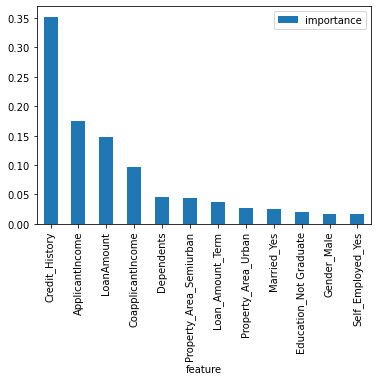


Confusion Matrix:


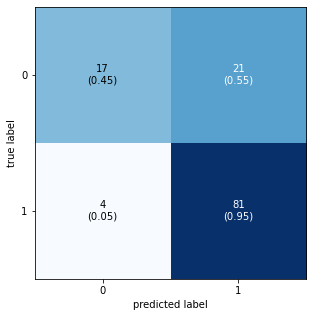

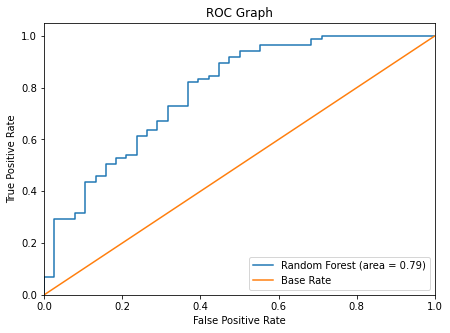

In [2]:
class ModelContainer:
    
    '''initializes models, dicts'''
    def __init__(self):  
        self.best_algorithm = None
        self.best_model = None
        self.predictions = None
        self.mean_score = {}
        self.gridcvs = {}
        self.parameters = {}
    
    
    def add_model(self, model):
        '''Adds models to the list'''
        self.models.append(model)

        
    def cross_validate(self, df):
        '''cross validate models using 5x2Cv nested cross-validation'''   
        clf1 = LogisticRegression(random_state=1)
        clf2 = RandomForestClassifier(random_state=1)
        clf3 = XGBClassifier(random_state=1)
                 
        param_grid1 = {'C': [0.01, 0.1, 1, 10, 100],
                     'penalty': ['l1', 'l2']}
    
        param_grid2 = {'n_estimators': [10, 100, 500, 1000, 10000]}
        
        param_grid3 = {'colsample_bytree':[0.6, 0.8], 
                         'max_depth': [8,10],
                         'min_child_weight':[3,7], 
                         'regsubsample' :[0.6, 0.8]}
        
        self.parameters= {clf1:param_grid1, clf2:param_grid2, clf3:param_grid3}
        

        inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

    
        for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                                     (clf1, clf2, clf3),
                                     ('Logistic','RandomForest','Xgboost')):

            gcv = GridSearchCV(estimator=est,
                               param_grid=pgrid,
                               scoring = 'roc_auc',
                               n_jobs=-1,                              
                               cv=inner_cv,
                               verbose=0,
                               refit=True)

            self.gridcvs[est] = gcv


        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
        for name, gs_est in (self.gridcvs.items()):
            nested_score = cross_val_score(gs_est, 
                                           X=df.feature_train, 
                                           y=df.target_train,                                            
                                           cv=outer_cv,
                                           n_jobs=-1)   
    
            self.mean_score[name] = nested_score.mean()

        
        self.best_algorithm = max(self.mean_score, key=self.mean_score.get)
        
        
         
    def tune_best_model(self, df):
        '''This function performs hyperparameter tuning on the whole training set with the best algorithm '''
        gcv_model_select = GridSearchCV(estimator=self.best_algorithm,
                                        param_grid=self.parameters[self.best_algorithm],
                                        scoring='roc_auc',
                                        n_jobs=-1,
                                        cv = 5,
                                        verbose=0,
                                        refit=True)

        gcv_model_select.fit(df.feature_train,df.target_train)
            
        self.best_model = gcv_model_select.best_estimator_
        self.best_score = gcv_model_select.best_score_
        self.best_params = gcv_model_select.best_params_
    
    
    def save_results(self):
        pass
    
     
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

        
    def print_summary(self,df):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:')
        print('\nBest Model:', models.best_model)
        train_roc = roc_auc_score(df.target_train, self.best_model.predict_proba(df.feature_train)[:, 1])
        test_roc  = roc_auc_score(df.target_test,  self.best_model.predict_proba(df.feature_test)[:, 1])
        print('\nAUC of Train Set:', train_roc)
        print('\nAUC of Test Set:', test_roc)
        print ('\nMatthews Correlation Coefficient', matthews_corrcoef(df.target_test, self.best_model.predict(df.feature_test)))   
        print ('\nBalanced Accuracy Score:', balanced_accuracy_score(df.target_test, self.best_model.predict(df.feature_test)))
        print('\nFeature Importances:\n', self.get_feature_importance(models.best_model, df.feature_train.columns))
        feature_importances = self.get_feature_importance(models.best_model, df.feature_train.columns)
        feature_importances.plot.bar()
        plt.show()
        
        print ('\nConfusion Matrix:')
        confmat=confusion_matrix(df.target_test, self.best_model.predict(df.feature_test))
        fig, ax = plot_confusion_matrix(conf_mat=confmat, show_absolute=True, show_normed=True, figsize=(5,5))
        
        fpr, tpr, thresholds = roc_curve(df.target_test, self.best_model.predict_proba(df.feature_test)[:,1])
        plt.figure(figsize=(7, 5))
        # Plot Random Forest Classifier ROC
        plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc_score(df.target_test,  self.best_model.predict_proba(df.feature_test)[:, 1]))
        # Plot Base Rate ROC
        plt.plot([0,1], [0,1],label='Base Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Graph')
        plt.legend(loc="lower right")


if __name__ == '__main__':
    
    #define number of processors to use for parallel runs
    num_procs = 4

    #set verbose level for models
    verbose_lvl = 0

    #define input files
    data_file = '/Users/vusalbabashov/Desktop/loan-classification/data/raw/loan_data_set.csv'


    #define variables
    cat_cols = ['Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'Property_Area', 'Credit_History']
    num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
    label_col = 'Loan_Status'
    id_col = 'Loan_ID'
    
  
    #Create Data object
    data = Data(data_file, cat_cols, num_cols, label_col, id_col)

    #Create model container
    models = ModelContainer()


    #Cross validate models, then select, fit, and score test data with best model
    models.cross_validate(data)
    models.tune_best_model(data)

    #Summarize results
    models.print_summary(data)